In [1]:
using Graphs
using Plots
using LinearAlgebra
using Statistics
include("../sis.jl")
include("../mpdbp.jl")
include("../exact/montecarlo.jl")
include("../glauber.jl")
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear);

In [2]:
q = q_sis
T = 10
k = 3
gg = binary_tree(k)
N = nv(gg)
g = IndexedGraph(gg)
λ = 0.2
κ = 0.15
p⁰ = map(1:N) do i
    r = 0.95
    [r, 1-r]
end
# ϕ = [[ones(2) for t in 1:T] for i in 1:N]

# # throw random observations
# nobs = 10
# its = rand(collect(Iterators.product(1:N, 1:T)), nobs)
# for (i, t) in its
#     r = rand()
#     ϕ[i][t] .= [r, 1-r]
# end

sis = SIS(g, λ, κ, T; p⁰);

In [3]:
bp = mpdbp(sis, d=1)
cb = CB_BP(bp);

In [4]:
nobs_node = N
draw_node_observations!(bp, nobs_node);

In [5]:
svd_trunc = TruncThresh(1e-3)
svd_trunc = TruncBond(2)
iterate!(bp, maxiter=100; svd_trunc, cb, tol=1e-3);

Running MPdBP: iter 2 	 Time: 0:00:18
  Δ:  1.5320381393418208

In [6]:
bond_dims.(bp.μ)

12-element Vector{Vector{Int64}}:
 [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
 [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
 [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
 [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
 [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
 [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
 [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
 [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
 [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
 [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
 [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
 [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

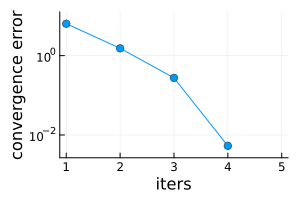

┌ Warning: Invalid negative or zero value 0.0 found at series index 5 for log10 based yscale
└ @ Plots /home/crotti/.julia/packages/Plots/jqILG/src/utils.jl:85


In [7]:
lb = minimum( filter(>(0), cb.Δs) ) / 2
ub = maximum( filter(>(0), cb.Δs) ) * 2
pl_err = plot(cb.Δs, ylabel="convergence error", xlabel="iters", m=:o, yaxis=(:log10, (lb, ub)),
    size=(300,200), label="")

In [8]:
b_bp = beliefs(bp)
p_bp = [[bbb[2] for bbb in bb] for bb in b_bp];

In [9]:
ns = 10^5
sms = sample(bp, ns)
b_mc = marginals(sms)
p_mc = [[bbb[2] for bbb in bb] for bb in b_mc];

SoftMargin sampling... 100%|█████████████████████████████| Time: 0:00:03


SIS on binary tree of depth k=3, N=7. P(S→I)=0.2, P(I→S)=0.15.
Max matrix size: 2x2


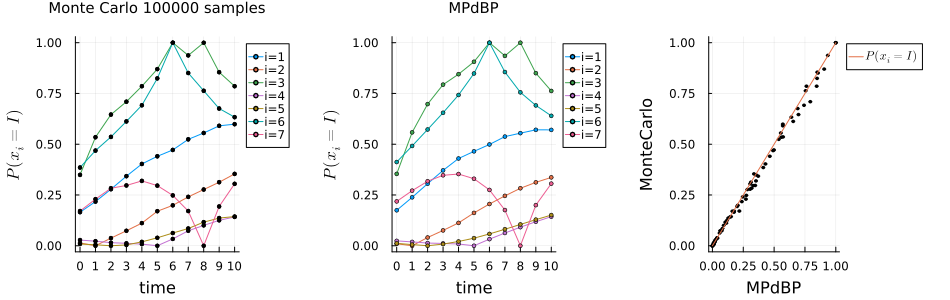

In [10]:
xt = 0:(T÷7):T
pl_mc = plot(xlabel="time", ylabel="\$P(x_i=I)\$", xticks=xt, title="Monte Carlo $ns samples")
for i in 1:N
    plot!(pl_mc, 0:T, p_mc[i], label="i=$i", m=:o, ms=2, lw=1)
end
pl_bp = plot(xlabel="time", ylabel="\$P(x_i=I)\$", xticks=xt, title="MPdBP")
for i in 1:N
    plot!(pl_bp, 0:T, p_bp[i], label="i=$i", m=:o, ms=2, lw=1)
end
println("SIS on binary tree of depth k=$k, N=$N. P(S→I)=$λ, P(I→S)=$κ.")
# println("$nobs random observations")
println("Max matrix size: ", svd_trunc.mprime, "x", svd_trunc.mprime)
pl_sc = scatter(reduce(vcat, p_bp), reduce(vcat, p_mc), xlabel="MPdBP", ylabel="MonteCarlo", 
        label="", ms=2, c=:black, legend=:outertopright)
plot!(identity, size=(300,300), ms=2, label="\$P(x_i=I)\$")
plot(pl_mc, pl_bp, pl_sc, titlefontsize=10, size=(950, 300), legend=:outertopright, 
    margin=5Plots.mm, layout=(1,3))